# Heat equation

## Problem setup
We will solve a heat equation:
$$
\frac{\partial u}{\partial t}=\alpha \frac{\partial^2u}{\partial x^2}, \qquad x \in [0, 1], \quad t \in [0, 1]
$$
where $alpha=0.4$ is the thermal diffusivity constant.

With Dirichlet boundary conditions:

$$
u(0,t) = u(1,t)=0,
$$

and periodic(sinusoidal) inital condition:
$$
u(x,0) = \sin (\frac{n\pi x}{L}),\qquad 0<x<L, \quad n = 1,2,.....
$$

where $L=1$ is the length of the bar, $n=1$ is the frequency of the sinusoidal initial conditions.

The exact solution is $u(x,t) = e^{\frac{-n ^2\pi ^2 \alpha t}{L^2}}\sin (\frac{n\pi x}{L})$.

## Implementation
This description goes through the implementation of a solver for the above described Heat equation step-by-step.

First, import the libraries we need:

In [1]:
import brainstate as bst
import numpy as np
import optax
import brainunit as u

import pinnx

We begin by defining the parameters of the equation:

In [2]:
a = 0.4 * u.meter2 / u.second # Thermal diffusivity
L = 1 * u.meter  # Length of the bar
n = 1 * u.Hz # Frequency of the sinusoidal initial conditions

Next, we define a computational geometry and time domain. We can use a built-in class `Interval` and `TimeDomain` and we combine both the domains using `GeometryXTime` as follows

In [3]:
geom = pinnx.geometry.Interval('x', 0 * u.meter, L)
timedomain = pinnx.geometry.TimeDomain('t', 0 * u.second, 1 * u.second)
geomtime = pinnx.geometry.GeometryXTime(geom, timedomain)

Next, we express the PDE residual of the Heat equation:

In [4]:
@bst.compile.jit
def pde(x, y):
    jacobian = approximator.jacobian(x)
    hessian = approximator.hessian(x)
    dy_t = jacobian['y']['t']
    dy_xx = hessian['y']['x']['x']
    return dy_t - a * dy_xx

The first argument to pde is 2-dimensional vector where the first component(`x[:,0]`) is x-coordinate and the second componenet (`x[:,1]`) is the t-coordinate. The second argument is the network output, i.e., the solution `u(x,t)`, but here we use `y` as the name of the variable.

Next, we consider the boundary/initial condition. We include the `geomtime` space, time geometry created above. We also define `IC` which is the inital condition for the burgers equation and we use the computational domain and initial function.

In [5]:
uy = u.kelvin / u.second
# Initial and boundary conditions:
bc = pinnx.icbc.DirichletBC(
    lambda x : {'y': 0. * uy}
)
ic = pinnx.icbc.IC(
    lambda x: {'y': u.math.sin(n * u.math.pi * x['x'][:] / L, unit_to_scale=u.becquerel) * uy},
)

Next, we choose the network. Here, we use a fully connected neural network of depth 4 (i.e., 3 hidden layers) and width 20:

In [6]:
approximator = pinnx.nn.Model(
    pinnx.nn.DictToArray(x=u.meter, t=u.second),
    pinnx.nn.FNN(
        [2] + [20] * 3 + [1],
        "tanh",
        bst.init.KaimingUniform()
    ),
    pinnx.nn.ArrayToDict(y=uy)
)

Now, we have specified the geometry, PDE residual, boundary/initial condition and approximator. We then define the TimePDE problem as

In [7]:
problem = pinnx.problem.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    approximator,
    num_domain=2540,
    num_boundary=80,
    num_initial=160,
    num_test=2540,
)

The number 2540 is the number of training residual points sampled inside the domain, and the number 80 is the number of training points sampled on the boundary. We also include 160 initial residual points for the initial conditions.

Now, we have the PDE problem and the network. We build a Model and choose the optimizer and learning rate:

In [8]:
trainer = pinnx.Trainer(problem)
trainer.compile(bst.optim.Adam(1e-3))

Compiling trainer...
'compile' took 0.052512 s



We then train the model for 10000 iterations:

In [9]:
trainer.train(iterations=10000)

Training trainer...

Step      Train loss                                                        Test loss                                                         Test metric 
0         [1.4850154 * 10.0^0 * ((kelvin / second) / second) ** 2,          [1.4892375 * 10.0^0 * ((kelvin / second) / second) ** 2,          []          
           {'ibc0': {'y': 0.2689446 * kelvin / second}},                     {'ibc0': {'y': 0.2689446 * kelvin / second}},                                
           {'ibc1': {'y': 0.8300821 * kelvin / second}}]                     {'ibc1': {'y': 0.8300821 * kelvin / second}}]                                
1000      [0.00331652 * 10.0^0 * ((kelvin / second) / second) ** 2,         [0.00207807 * 10.0^0 * ((kelvin / second) / second) ** 2,         []          
           {'ibc0': {'y': 0.00315691 * kelvin / second}},                    {'ibc0': {'y': 0.00315691 * kelvin / second}},                               
           {'ibc1': {'y': 0.00563422 * kelvin / s

After we train the network using Adam, we continue to train the network using L-BFGS to achieve a smaller loss:

In [10]:
trainer.compile(bst.optim.OptaxOptimizer(optax.lbfgs(1e-3, linesearch=None)))
trainer.train(iterations=2000)

Compiling trainer...
'compile' took 0.091994 s

Training trainer...

Step      Train loss                                                           Test loss                                                             Test metric 
10000     [1.724144e-05 * 10.0^0 * ((kelvin / second) / second) ** 2,          [1.5484915e-05 * 10.0^0 * ((kelvin / second) / second) ** 2,          []          
           {'ibc0': {'y': 2.8767242e-06 * kelvin / second}},                    {'ibc0': {'y': 2.8767242e-06 * kelvin / second}},                                
           {'ibc1': {'y': 1.1067352e-06 * kelvin / second}}]                    {'ibc1': {'y': 1.1067352e-06 * kelvin / second}}]                                
11000     [1.7115863e-05 * 10.0^0 * ((kelvin / second) / second) ** 2,         [1.5460057e-05 * 10.0^0 * ((kelvin / second) / second) ** 2,          []          
           {'ibc0': {'y': 2.6213843e-06 * kelvin / second}},                    {'ibc0': {'y': 2.6213843e-06 * kelvin / s

Let's visualize and save the data.

Saving loss history to c:\Github\pinnx\docs\examples-pinn-forward\loss.dat ...
Saving checkpoint into c:\Github\pinnx\docs\examples-pinn-forward\loss.dat
Saving training data to c:\Github\pinnx\docs\examples-pinn-forward\train.dat ...
Saving checkpoint into c:\Github\pinnx\docs\examples-pinn-forward\train.dat
Saving test data to c:\Github\pinnx\docs\examples-pinn-forward\test.dat ...
Saving checkpoint into c:\Github\pinnx\docs\examples-pinn-forward\test.dat


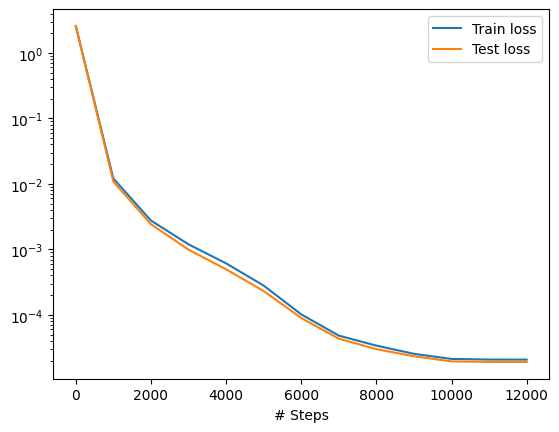

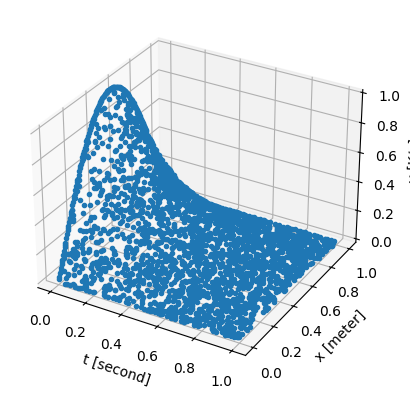

In [11]:
trainer.saveplot(issave=True, isplot=True)